In [1]:
from typing import Tuple, Dict

import pandas as pd
import numpy as np
import cv2
import pathlib

from utils.misc import get_items_on_path
from utils.vision.transformation import get_image_and_reshape, transform_image_contrast, grayscale_mask
from utils.vision.models import unet_model
from utils.callback import LRFinder
from training import prepare_X_and_y

import hydra
from hydra import initialize, compose
from omegaconf import OmegaConf

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import Binarizer

import matplotlib.pyplot as plt
%matplotlib inline
initialize("./configs")


hydra.initialize()

In [3]:
cfg = compose(config_name="config.yaml")
np.random.seed(cfg.project_setup.RANDOM_STATE_N)

PATH_TRAIN_IMAGE_FOLDER = pathlib.Path(cfg.project_setup.paths.data.TRAIN_IMAGE_FOLDER)
PATH_TRAIN_METADATA = pathlib.Path(cfg.project_setup.paths.data.TRAIN_METADATA)

print(OmegaConf.to_yaml(cfg))

project_setup:
  paths:
    data:
      TRAIN_IMAGE_FOLDER: ./data/train
      TRAIN_METADATA: ./data/train.csv
    model:
      MODEL_FOLDER: ./data/models
  RANDOM_STATE_N: 19
  tensorboard:
    SERVER_PORT: 6006
    LOG_DIR: logs
preprocessing:
  INPUT_SHAPE:
    HEIGHT: 520
    WIDTH: 704
  OUTPUT_SHAPE:
    HEIGHT: 512
    WIDTH: 704
  TRANS_POWER: 2
training:
  device:
    GPU: 1
  model:
    LEARNING_RATE: 0.0001
    VAL_SIZE: 0.1
    BATCH_SIZE: 4
    EPOCHS: 20
    PATIENCE: 6



In [4]:
# read meta data
train_metadata = pd.read_csv(PATH_TRAIN_METADATA)

## load all train images into memory as dictionary with image_id as key and the image (np.ndarray) as value
input_img_shape = (cfg.preprocessing.INPUT_SHAPE.HEIGHT, cfg.preprocessing.INPUT_SHAPE.WIDTH)

train_images_paths = get_items_on_path(PATH_TRAIN_IMAGE_FOLDER)
train_images = [get_image_and_reshape(train_image_path, input_img_shape) for train_image_path in train_images_paths]
train_images_dict = {image_id: image for image, image_id in train_images}

Data Preparation
Loading and Transforming the images into their corresponding grayscale masks

In [5]:
X, y = prepare_X_and_y(cfg=cfg, ids_and_images=train_images_dict, metadata=train_metadata)

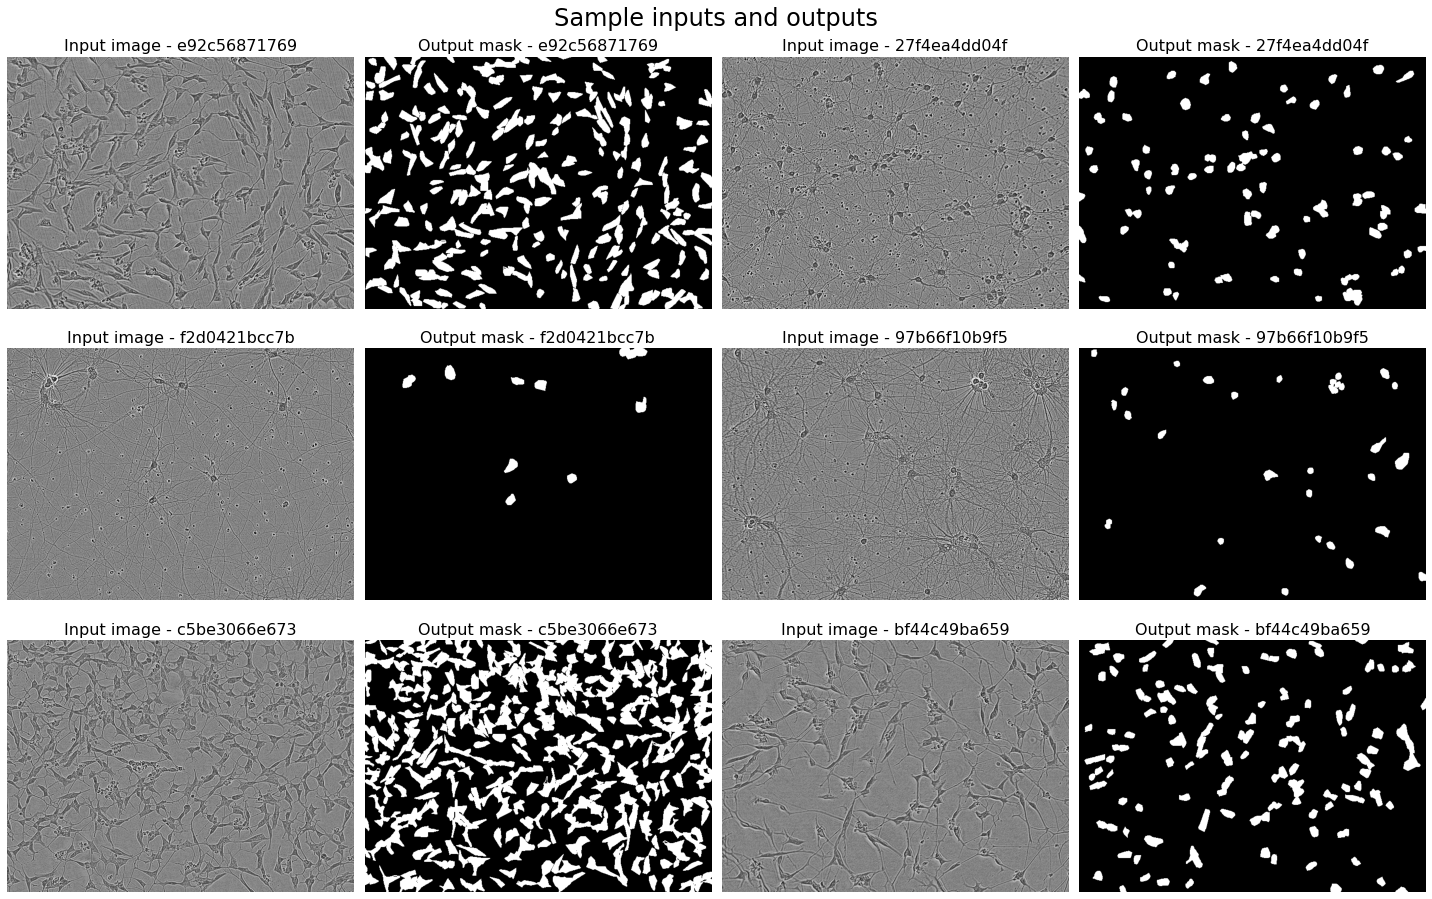

In [6]:
image_ids = list(train_images_dict.keys())

plt.figure(figsize = (20 , 13))

for idx_cnt, idx_rnd_image in enumerate(np.random.randint(len(image_ids), size = 6)):
    plt.subplot(3, 4, (idx_cnt * 2) + 1)
    plt.imshow(X[idx_rnd_image], cmap = 'gray')
    plt.title(f'Input image - {image_ids[idx_rnd_image]}', fontsize = 16)
    plt.axis("off")
    
    plt.subplot(3, 4, (idx_cnt * 2) + 2)
    plt.imshow(y[idx_rnd_image], cmap = 'gray')
    plt.title(f'Output mask - {image_ids[idx_rnd_image]}', fontsize = 16)
    plt.axis("off")
    
plt.suptitle("Sample inputs and outputs", fontsize = 24)
plt.tight_layout()
plt.show()

In [7]:
model=unet_model((cfg.preprocessing.OUTPUT_SHAPE.HEIGHT, cfg.preprocessing.OUTPUT_SHAPE.WIDTH, 1))
model.compile(optimizer = Adam(cfg.training.model.LEARNING_RATE), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "Sartorius"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 512, 704, 1) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 512, 704, 16) 416         Input_Layer[0][0]                
__________________________________________________________________________________________________
Max_Pool_1 (MaxPooling2D)       (None, 256, 352, 16) 0           Conv_1[0][0]                     
__________________________________________________________________________________________________
SPD_1 (SpatialDropout2D)        (None, 256, 352, 16) 0           Max_Pool_1[0][0]                 
__________________________________________________________________________________________

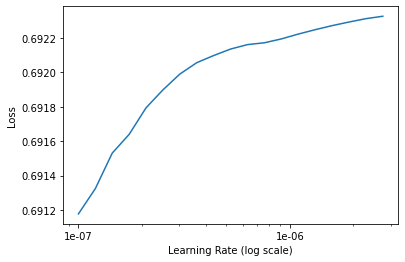

In [8]:
lr_finder = LRFinder()
with tf.device(f'/device:GPU:{cfg.training.device.GPU}'):
    _ = model.fit(X, y, callbacks=[lr_finder], verbose=False)
lr_finder.plot()